# Make Plots
Generate the comparisions between SchNet and QML

In [1]:
%matplotlib inline
from jcesr_ml.benchmark import load_benchmark_data
from jcesr_ml.style import model_style
from matplotlib import pyplot as plt
from ase.units import Hartree, eV
import pandas as pd
import numpy as np
import json
import os

Key lookup values

In [2]:
qml_dir = os.path.join('qml')
schnet_dir = os.path.join('schnet')
test_data_size = len(load_benchmark_data()[1])
models_to_plot = ['g4mp2-delta', 'g4mp2-transfer', 'g4mp2']

## Read in the Results
Get the results from QML, SchNet calculations and the baseline data

In [3]:
schnet_results = pd.read_json(os.path.join(schnet_dir, 'g4mp2-models.json'))

In [4]:
schnet_results.query('size == 117232').sort_values('mae')

,converged,mae,name,run_time,size
4,True,0.004455,g4mp2-delta,646.861267,117232
10,True,0.013404,g4mp2-transfer,650.542225,117232
19,True,0.014336,g4mp2-charges-in-outnet,639.473399,117232
7,True,0.014799,g4mp2-charges,634.996836,117232
16,True,0.014839,g4mp2-stacked-delta,1250.448087,117232
1,True,0.014916,g4mp2,645.036228,117232
13,True,0.024844,g4mp2-multitask,634.307891,117232


In [5]:
schnet_results.query('size == 1000').sort_values('mae')

,converged,mae,name,run_time,size
3,True,0.030114,g4mp2-delta,665.613616,1000
9,True,0.084842,g4mp2-transfer,638.611092,1000
15,False,0.087266,g4mp2-stacked-delta,1206.495928,1000
18,True,0.233222,g4mp2-charges-in-outnet,654.748736,1000
0,True,0.238957,g4mp2,649.026785,1000
6,False,0.250619,g4mp2-charges,635.860621,1000
12,False,0.316182,g4mp2-multitask,644.532931,1000


In [6]:
schnet_predictions = pd.read_csv(os.path.join(schnet_dir, 'schnet_predictions.csv.gz'))

Compare the two charges approaches

In [7]:
schnet_results[schnet_results['name'].str.contains('charges')]

,converged,mae,name,run_time,size
18,True,0.233222,g4mp2-charges-in-outnet,654.748736,1000
19,True,0.014336,g4mp2-charges-in-outnet,639.473399,117232
20,True,0.068183,g4mp2-charges-in-outnet,653.984617,10000
6,False,0.250619,g4mp2-charges,635.860621,1000
7,True,0.014799,g4mp2-charges,634.996836,117232
8,True,0.068879,g4mp2-charges,647.063032,10000


Load the FCHL data

In [8]:
with open(os.path.join(qml_dir, 'fchl.json')) as fp:
    qml_results = pd.DataFrame.from_records(json.load(fp)['g4mp2_benchmark'])

In [9]:
qml_results

,mae,test_time,train_size,train_time
0,0.041503,87.115176,10.0,0.149087
1,0.011979,668.050757,100.0,2.524154
2,0.002458,7586.430827,1000.0,279.609858
3,0.000820,89427.240106,10000.0,34191.970684


In [10]:
with open(os.path.join(qml_dir, 'fchl-delta.json')) as fp:
    qml_delta_results = pd.DataFrame.from_records(json.load(fp)['g4mp2_with_b3lyp_results'])

In [11]:
qml_delta_results

,mae,test_time,train_size,train_time
0,0.004968,85.386432,10.0,0.130719
1,0.001460,643.299935,100.0,2.410578
2,0.000426,7783.987396,1000.0,296.710287
3,0.000190,89210.823406,10000.0,34101.141370


In [12]:
qml_predictions = pd.read_csv(os.path.join(qml_dir, 'fchl-predictions.csv.gz'))

Load in baseline results

In [13]:
with open(os.path.join(schnet_dir, 'baseline-stats.json')) as fp:
    baseline = json.load(fp)

## Make the Comparison between SchNet and QML
Constrast their performance and run-time speeds

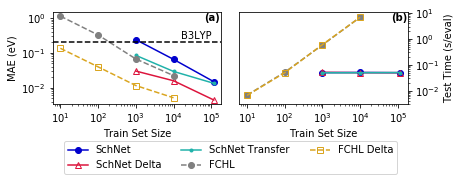

In [14]:
fig, axs = plt.subplots(1, 2)

# Initialize list of handles
handles = []
labels = []

# Add in the SchNet data
for gid, group in schnet_results.groupby('name'):
    if not gid in models_to_plot: continue
    group = group.sort_values('size')

    hdl = axs[0].loglog(group['size'], group['mae'], **model_style[gid])
    axs[1].loglog(group['size'], group['run_time'] / test_data_size, **model_style[gid])
    handles.append(hdl[0])
    labels.append(model_style[gid]['label'])

# Add in QML
hdl = axs[0].semilogy(qml_results['train_size'], 
                     qml_results['mae'] * Hartree / eV,
                     **model_style['FCHL'])
axs[1].loglog(qml_results['train_size'], qml_results['test_time'] / test_data_size, **model_style['FCHL'])
handles.append(hdl[0])
labels.append('FCHL')

dl = axs[0].semilogy(qml_delta_results['train_size'], 
                     qml_delta_results['mae'] * Hartree / eV,
                     **model_style['FCHL Delta'])
hdl = axs[1].loglog(qml_delta_results['train_size'], 
              qml_delta_results['test_time'] / test_data_size, **model_style['FCHL Delta'])
handles.append(hdl[0])
labels.append('FCHL Delta')
    
# Mark the baseline accuracies
for ax in axs:
    ax.set_xlim(ax.get_xlim())

#  Accuracy of b3lyp atomization energy
val = baseline['u0_atomization_mae']
axs[0].plot(axs[0].get_xlim(), [val]*2, 'k--')
axs[0].text(1e5, val * 1.1, 'B3LYP', ha='right', va='bottom')

# Make the labels
for ax, l in zip(axs, ['(a)', '(b)']):
    ax.text(0.9, 0.9, l, transform=ax.transAxes, fontweight='demibold')
    ax.set_xlabel('Train Set Size')
axs[0].set_ylabel('MAE (eV)')
axs[1].yaxis.tick_right()
axs[1].set_ylabel('Test Time (s/eval)')
axs[1].yaxis.set_label_position("right")
axs[1].set_ylim(3e-3, 11)

fig.legend(handles, labels, loc='lower center', ncol=3)

fig.set_size_inches(6.5, 2.5)
fig.tight_layout(rect=[0,0.15,1,1])
fig.savefig(os.path.join('figures', 'g4mp2-learning-curve.png'), dpi=320)

In [15]:
improvement = (qml_results.query('train_size == 100')['mae'].iloc[0]
              * Hartree / eV / schnet_results.query('name == "g4mp2"')['mae'].min())
print('For comparable evaluation speeds, SchNet is {:.1f}x more accurate'.format(improvement))

For comparable evaluation speeds, SchNet is 21.9x more accurate


## Plot Error Distributions
Show the distribution of errors for the largest training set sizes

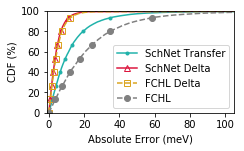

In [16]:
fig, ax = plt.subplots()

points = np.linspace(0, 100, 151)

# Plot SchNet Transfer
error = (schnet_predictions['g4mp2_0k'] - schnet_predictions['ypred-g4mp2-transfer-117232']).abs() * Hartree / eV * 1000
ax.plot([np.percentile(error, x) for x in points], points, markevery=20, **model_style['g4mp2-transfer'])

# Plot SchNet Delta
error = (schnet_predictions['g4mp2_0k'] - schnet_predictions['ypred-g4mp2-delta-117232']).abs() * Hartree / eV * 1000
ax.plot([np.percentile(error, x) for x in points], points, markevery=20, **model_style['g4mp2-delta'])

# Plot FCHL Delta predictions
error = (qml_predictions['delta'] - qml_predictions['pred_y_10000-delta']).abs() * Hartree / eV * 1000
ax.plot([np.percentile(error, x) for x in points], points, markevery=20, **model_style['FCHL Delta'])

# Plot FCHL predictions
error = (qml_predictions['g4mp2_atom'] - qml_predictions['pred_y_10000']).abs() * Hartree / eV * 1000
ax.plot([np.percentile(error, x) for x in points], points, markevery=20, **model_style['FCHL'])

ax.legend()

# Make axes labels
ax.set_xlabel('Absolute Error (meV)')
ax.set_xlim(-1, 105)
ax.set_ylabel('CDF (%)')
ax.set_ylim(0, 100)

fig.set_size_inches(3.5, 2.2)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'error-cdf.png'), dpi=320)

*Finding*: Nothing surprising in the error distribution: the ML models with the best MAE will likely have the best 95% error, RMSE, etc.